In [1]:
#importando as bibliotecas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from scipy import stats as st

games = pd.read_csv('/datasets/games.csv')

In [2]:
games.info()
print()
print(games)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   


A lista conta com vários valores ausentes, principalmente as notas de avaliações tanto de críticos quanto usuários, além da classificação parental. Para jogos antigos é normal não possuírem essas informações por terem sido lançado antes da implementação dessas notas e classificações. Jogos com baixas vendas também não possuem esses valores também.

In [3]:
#convertendo os nomes das colunas para minúsculo
new_names=[]
for old_names in games.columns:
    name_lower = old_names.lower()
    new_names.append(name_lower)

games.columns=new_names

In [4]:
#convertendo os tipos dos dados
for index, row in games[games['year_of_release'].isnull()].iterrows():
    nome_jogo = row['name']
    
    jogos_mesmo_nome = games[(games['name'] == nome_jogo) & (games['year_of_release'].notnull())]
    
    if not jogos_mesmo_nome.empty:
        ano_encontrado = jogos_mesmo_nome['year_of_release'].mode()[0]  # Mais comum
       
        games.at[index, 'year_of_release'] = ano_encontrado

games['year_of_release'] = games['year_of_release'].fillna(games.groupby('platform')['year_of_release'].transform('mean').round())
games['year_of_release'] = games['year_of_release'].astype('int')

In [5]:
#substituindo tbd por NaN
games['user_score'] = games['user_score'].replace('tbd',np.nan)
games['user_score'] = games['user_score'].astype('float')


In [6]:
#name, verifiquei com método isna() que há dois jogos que não possuem nome
#vou atribuir o termo 'Unknown' para os mesmos
games['name'] = games['name'].fillna('Unknown')

In [7]:
#genre, os mesmos dois jogos que estão sem nome, também não possuem classificação de gênero
#da mesma forma, vou atribuir o termo 'Unknown'
games['genre'] = games['genre'].fillna('Unknown')

## Resumo dos dados
Depois da análise, decidi por alterar o tipo de algumas colunas: 
* *years_of_release* foi alterada para 'int', já que os anos não possui 'float'. Para fazer a alteração do tipo de dados, optei por excluir os valores de NaN que impedia a alteração;
* *user_score* estava como objeto, e para transformar em float, tive que substituir os 'tbd' para -1, número que é único para notas, visto que não há notas negativas. A princípio manterei assim para fins de utilização em cálculos;
* *name* e *genre* foi identificado duas linhas como NaN, e as substituí por 'Unknown'.

Demais dados e tipos foram mantidos. A princípio não vi a necessidade de alterar nada mais, conforme o progresso talvez eu tenha que mexer em algo a mais.

In [8]:
#Calculando o total de vendas
total_sales = []
for index, row in games.iterrows():
    na_row = row['na_sales']
    eu_row = row['eu_sales']
    jp_row = row['jp_sales']
    other_row = row['other_sales']
    total = na_row + eu_row + jp_row + other_row
    total_sales.append(total)
games['total_sales'] = total_sales
print(games)

                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii             2006        Sports   
1                  Super Mario Bros.      NES             1985      Platform   
2                     Mario Kart Wii      Wii             2008        Racing   
3                  Wii Sports Resort      Wii             2009        Sports   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16711               LMA Manager 2007     X360             2006        Sports   
16712        Haitaka no Psychedelica      PSV             2016     Adventure   
16713               Spirits & Spells      GBA             2003      Platform   
16714            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  ot

In [9]:
#Total de jogos lançados a cada ano

launches = games.groupby(['year_of_release']).agg({'name': 'count'}).reset_index()
print(launches)

    year_of_release  name
0              1980     9
1              1981    46
2              1982    52
3              1983    17
4              1984    14
5              1985    14
6              1986    21
7              1987    16
8              1988    15
9              1989    17
10             1990    16
11             1991    41
12             1992    43
13             1993    62
14             1994   122
15             1995   219
16             1996   264
17             1997   289
18             1998   386
19             1999   340
20             2000   351
21             2001   486
22             2002   845
23             2003   796
24             2004   771
25             2005   969
26             2006  1019
27             2007  1202
28             2008  1463
29             2009  1459
30             2010  1282
31             2011  1164
32             2012   662
33             2013   553
34             2014   582
35             2015   606
36             2016   502


Com o passar dos anos, novas plataformas foram criadas e consequentemente há um maior número de lançamentos, pois o mesmo jogo pode ser lançados em n plataformas. Temos um pico em 2009 e 2010, e posteriormente houve uma redução, pela saída de algumas plataformas.

In [10]:
#Maiores vendas por plataforma
platform_sales = games.groupby(['platform']).agg({'total_sales': 'sum'}).reset_index()
platform_sales = platform_sales.sort_values('total_sales', ascending=False).reset_index(drop=True)
print(platform_sales)

   platform  total_sales
0       PS2      1255.77
1      X360       971.42
2       PS3       939.65
3       Wii       907.51
4        DS       806.12
5        PS       730.86
6       GBA       317.85
7       PS4       314.14
8       PSP       294.05
9        PC       259.52
10      3DS       259.00
11       XB       257.74
12       GB       255.46
13      NES       251.05
14      N64       218.68
15     SNES       200.04
16       GC       198.93
17     XOne       159.32
18     2600        96.98
19     WiiU        82.19
20      PSV        54.07
21      SAT        33.59
22      GEN        30.77
23       DC        15.95
24      SCD         1.86
25       NG         1.44
26       WS         1.42
27     TG16         0.16
28      3DO         0.10
29       GG         0.04
30     PCFX         0.03


In [11]:
games.loc[15957, 'year_of_release'] = 2010
sales_per_year = games.groupby(['year_of_release', games['platform']]).agg({'total_sales': 'sum'}).reset_index()
platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS']
top_platforms = sales_per_year[sales_per_year['platform'].isin(platform)]
print(top_platforms)

     year_of_release platform  total_sales
95              2000      PS2        39.17
105             2001      PS2       166.43
114             2002      PS2       208.36
120             2003      PS2       193.05
122             2004       DS        17.27
127             2004      PS2       211.81
130             2005       DS       130.14
134             2005      PS2       169.52
135             2005      PS3         0.19
137             2005     X360         9.22
139             2006       DS       119.81
143             2006      PS2       103.99
144             2006      PS3        21.44
146             2006      Wii       140.19
147             2006     X360        51.79
150             2007       DS       147.23
154             2007      PS2        76.10
155             2007      PS3        73.19
157             2007      Wii       153.41
158             2007     X360        95.41
161             2008       DS       147.20
163             2008      PS2        53.90
164        

### Alteração de dados em uma linha do df original

Após montar a lista com o total de vendas de jogos, me deparei que um jogo lançado para Nintendo DS continha o ano de lançamento como 1985, sendo que o console portátil foi lançado em 2004. Localizei a linha e pesquisei o jogo 'Strongest Tokyo University Shogi DS', e a data de lançamento do mesmo foi no ano de 2010. Fiz essa correção.

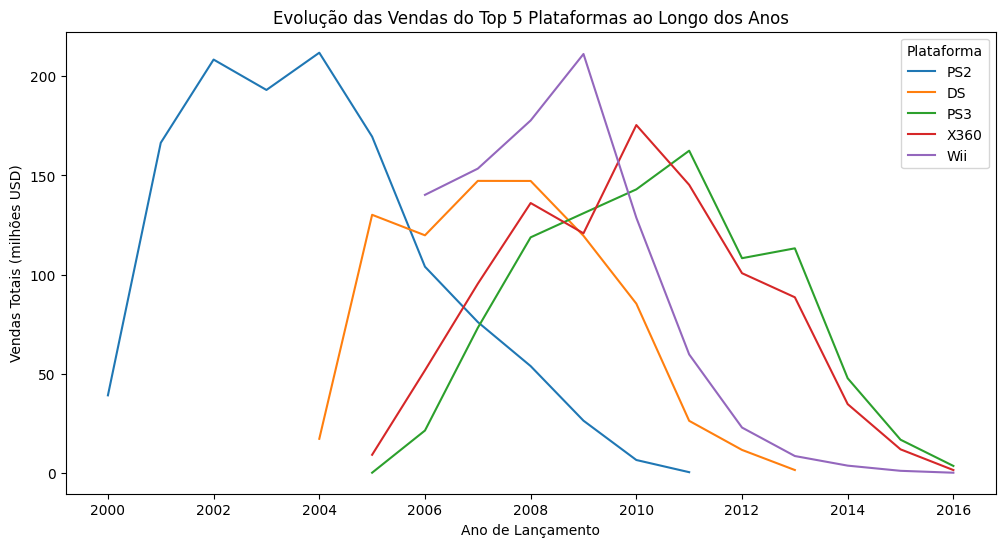

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_platforms, 
             x='year_of_release', 
             y='total_sales', 
             hue='platform')
plt.title('Evolução das Vendas do Top 5 Plataformas ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Vendas Totais (milhões USD)')
plt.legend(title='Plataforma')
plt.show()

O PS2 teve um longo período de lançamentos, estando ligado ao motivo de ter sido top 1 em vendas globais. Com lançamentos de outros consoles ou de atualização de gerações, acabou tendo uma queda nas vendas, por conta de limitações de hardware que era exigido dos novos jogos da época. Consoles que apresentaram diferentes ideias ou maneiras de jogar, como o Nintendo Wii e seu controle como diferencial para a experiência, também tiveram um grande número de vendas. O período médio de vendas é cerca de 10 anos para cada console.

In [13]:
filtered_years = games[games['year_of_release'] >= 2012]
top_sales = filtered_years.groupby('platform')['total_sales'].sum().sort_values(ascending=False).reset_index()
print(top_sales.head(10))

  platform  total_sales
0      PS4       314.14
1      PS3       289.71
2     X360       237.52
3      3DS       195.48
4     XOne       159.32
5     WiiU        82.19
6       PC        63.51
7      PSV        49.44
8      Wii        36.60
9       DS        13.21


In [14]:
year_1 = 2014
year_5 = 2016

vendas_inicio = filtered_years[filtered_years['year_of_release'] == year_1].groupby('platform')['total_sales'].sum()
vendas_fim = filtered_years[filtered_years['year_of_release'] == year_5].groupby('platform')['total_sales'].sum()
crescimento = ((vendas_fim - vendas_inicio) / vendas_inicio * 100).sort_values(ascending=False).reset_index()
print("Crescimento das plataformas (%):")
print(crescimento.head(10))

Crescimento das plataformas (%):
  platform  total_sales
0      PS4   -30.750000
1     XOne   -51.636767
2       PC   -60.466867
3      PSV   -65.049342
4      3DS   -65.402194
5     WiiU   -79.119383
6      PS3   -92.462312
7      Wii   -95.200000
8     X360   -95.624640
9      PSP          NaN


## Tendência negativa
Após filtrar os lançamentos, separeri os útlimos 3 anos disponíveis para a obtenção da taxa de crescimento. Porém, os resultaram foram negativos, representando uma queda nas vendas de jogos. A menor queda foi do PS4.

In [15]:
#Top vendas em 2016
print(vendas_fim.sort_values(ascending=False))

platform
PS4     69.25
XOne    26.15
3DS     15.14
PC       5.25
WiiU     4.60
PSV      4.25
PS3      3.60
X360     1.52
Wii      0.18
Name: total_sales, dtype: float64


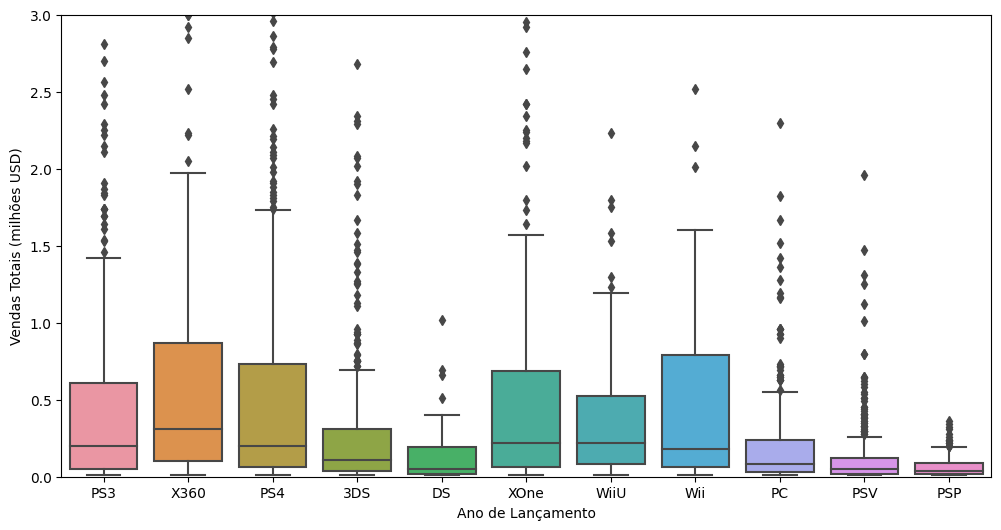

In [16]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_years, 
             x='platform', 
             y='total_sales', 
             )
plt.ylim(0, 3)
plt.xlabel('Ano de Lançamento')
plt.ylabel('Vendas Totais (milhões USD)')
plt.show()


Utilizei o filtro para jogos lançados a partir de 2012, e há diferenças grandes entre consoles portáteis e de mesa, sendo a venda dos de mesa maiores. Entre os consoles de mesa há uma similaridade nas médias.

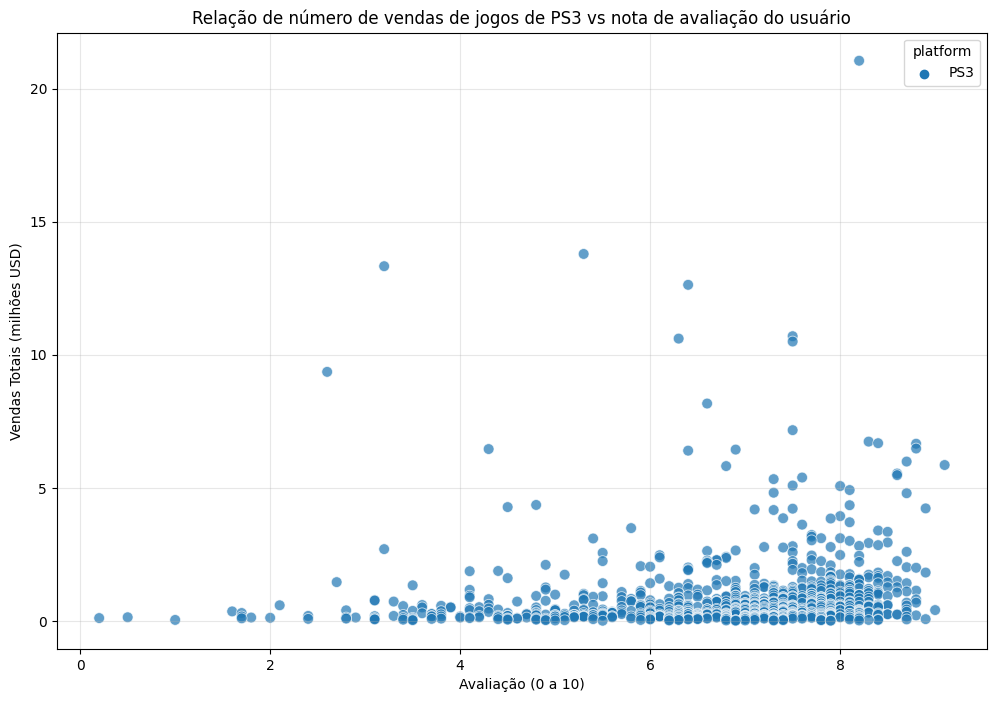

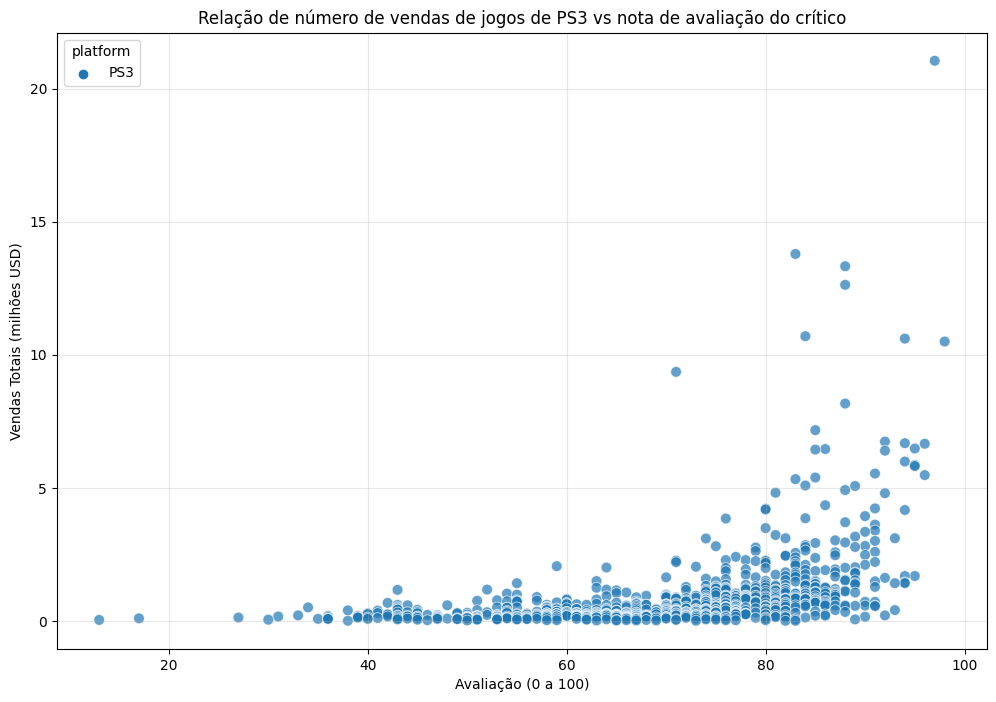

In [17]:
ps3_scores = games[games['platform']=='PS3']
plt.figure(figsize=(12, 8))
sns.scatterplot(data=ps3_scores, 
                x='user_score', 
                y='total_sales',
                hue='platform',
                s=60,  # tamanho dos pontos
                alpha=0.7)  # transparência

plt.title('Relação de número de vendas de jogos de PS3 vs nota de avaliação do usuário')
plt.xlabel('Avaliação (0 a 10)')
plt.ylabel('Vendas Totais (milhões USD)')
plt.grid(True, alpha=0.3)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=ps3_scores, 
                x='critic_score',
                y='total_sales',
                hue='platform',
                s=60,  # tamanho dos pontos
                alpha=0.7)  # transparência

plt.title('Relação de número de vendas de jogos de PS3 vs nota de avaliação do crítico')
plt.xlabel('Avaliação (0 a 100)')
plt.ylabel('Vendas Totais (milhões USD)')
plt.grid(True, alpha=0.3)

plt.show()

In [18]:
print('A correlação entre avaliação dos usuários é:',ps3_scores['user_score'].corr(ps3_scores['total_sales']))
print('A correlação entre avaliação dos críticos é:',ps3_scores['critic_score'].corr(ps3_scores['total_sales']))

A correlação entre avaliação dos usuários é: 0.12669133936341692
A correlação entre avaliação dos críticos é: 0.43243156856420634


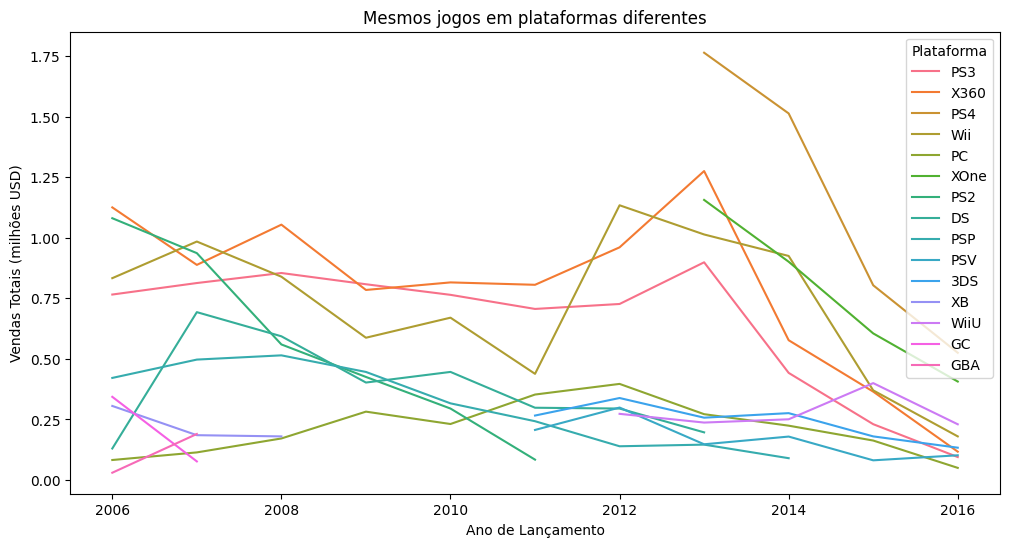

In [19]:

find = games[games['name'].isin(ps3_scores['name'])]

platforms_comparsion = pd.concat([ps3_scores, find], ignore_index=True)
filter_years = platforms_comparsion[platforms_comparsion['year_of_release'] >= 2006]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filter_years, 
             x='year_of_release', 
             y='total_sales', 
             markers=True,
             ci=None,
             hue='platform')
plt.title('Mesmos jogos em plataformas diferentes')

plt.xlabel('Ano de Lançamento')

plt.ylabel('Vendas Totais (milhões USD)')
plt.legend(title='Plataforma')
plt.show()



Unindo as plataformas, é possível reparar que o console Xbox 360 é a mais similar ao PS3, apesar do Xbox ter um número superior de vendas. Os consoles portáteis ou de gerações anteriores estão com vendas mais parecidas entre si.

In [20]:
top_genres = games.groupby('genre')['total_sales'].sum().sort_values(ascending=False).reset_index()
print(top_genres)

           genre  total_sales
0         Action      1744.17
1         Sports      1331.27
2        Shooter      1052.45
3   Role-Playing       934.56
4       Platform       827.77
5           Misc       802.51
6         Racing       728.67
7       Fighting       447.53
8     Simulation       389.97
9         Puzzle       242.57
10     Adventure       237.59
11      Strategy       174.23
12       Unknown         2.42


Os gêneros mais lucrativos podem estar ligado a vários fatores, jogos com opções de multiplayer, esportes que já tem um público que assiste/acompanha e quer estar mais próximo.
Não creio ser adequado generalizar os gêneros das vendas altas ou baixas, pois podem haver grandes sucessos em um gênero que no geral não tem tantas vendas.

In [21]:

na_sale = games.groupby('platform')['na_sales'].sum().sort_values(ascending=False).reset_index()
eu_sale = games.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).reset_index()
jp_sale = games.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).reset_index()
top_na= na_sale[:5]
top_eu = eu_sale[:5]
top_jp = jp_sale[:5]
print(top_na)
print()
print(top_eu)
print()
print(top_jp)


  platform  na_sales
0     X360    602.47
1      PS2    583.84
2      Wii    496.90
3      PS3    393.49
4       DS    382.40

  platform  eu_sales
0      PS2    339.29
1      PS3    330.29
2     X360    270.76
3      Wii    262.21
4       PS    213.61

  platform  jp_sales
0       DS    175.57
1       PS    139.82
2      PS2    139.20
3     SNES    116.55
4      3DS    100.67


Pode-se verificar a dominância dos consoles de mesa em geral para os mercados norte americanos e europa, com Playstation e Xbox competindo pelo topo. Já no japão, a vitória foi de um portátil da Nintendo, também sendo o único dos três a conter dois portáteis no top 5.

In [22]:
na_genre = games.groupby('genre')['na_sales'].sum().sort_values(ascending=False).reset_index()
eu_genre = games.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).reset_index()
jp_genre = games.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).reset_index()
top_genre_na= na_genre[:5]
top_genre_eu = eu_genre[:5]
top_genre_jp = jp_genre[:5]
print(top_genre_na)
print()
print(top_genre_eu)
print()
print(top_genre_jp)


      genre  na_sales
0    Action    879.01
1    Sports    684.43
2   Shooter    592.24
3  Platform    445.50
4      Misc    407.27

     genre  eu_sales
0   Action    519.13
1   Sports    376.79
2  Shooter    317.34
3   Racing    236.51
4     Misc    212.74

          genre  jp_sales
0  Role-Playing    355.41
1        Action    161.43
2        Sports    135.54
3      Platform    130.83
4          Misc    108.11


Gostos muito parecidos entre América do Norte e Europa, com o mesmo top 3 para os gêneros. O Japão substitui o gênero shooter e consagra o Role-Playing no seu top 3, visto que muitas franquias famosas de Role-Playing são originadas no Japão.

  rating  na_sales
0      E   1292.99
1      T    759.75
2      M    748.48
3   E10+    353.32
4    K-A      2.56
5     EC      1.53
6     AO      1.26
7     RP      0.00

  rating  eu_sales
0      E    710.25
1      M    483.97
2      T    427.03
3   E10+    188.52
4     AO      0.61
5    K-A      0.27
6     EC      0.11
7     RP      0.08

  rating  jp_sales
0      E    198.11
1      T    151.40
2      M     64.24
3   E10+     40.20
4    K-A      1.46
5     AO      0.00
6     EC      0.00
7     RP      0.00


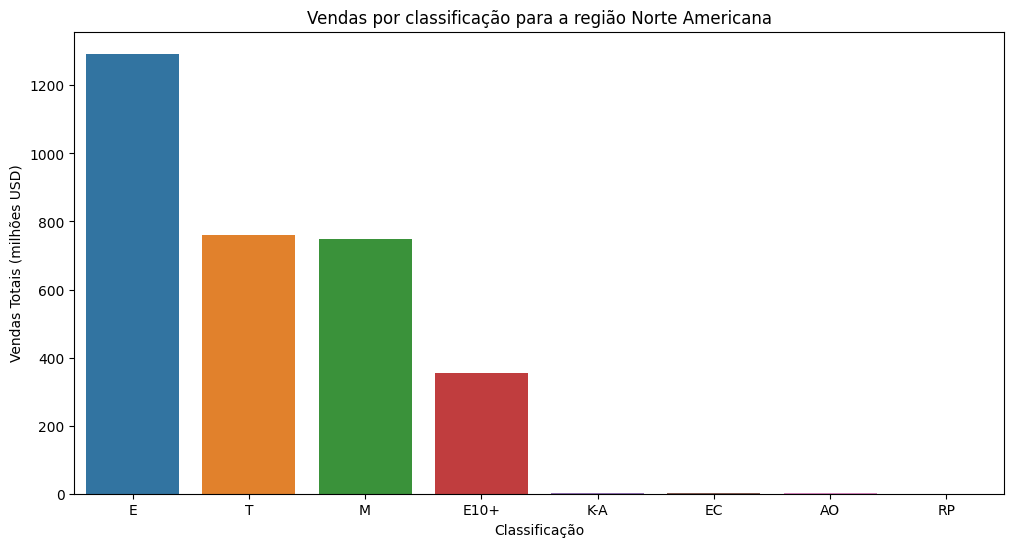

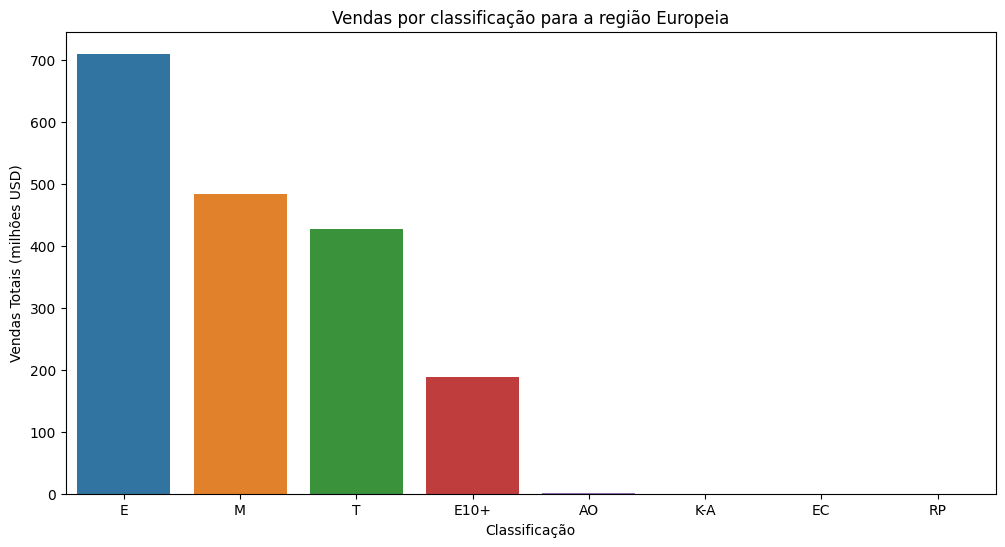

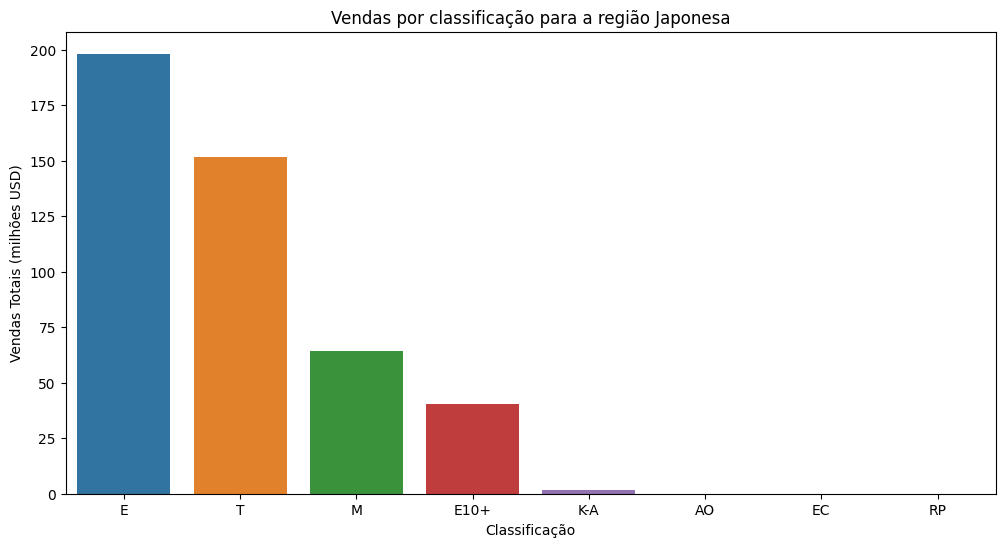

In [23]:
eu_rating_sales = games.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).reset_index()
na_rating_sales = games.groupby('rating')['na_sales'].sum().sort_values(ascending=False).reset_index()
jp_rating_sales = games.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).reset_index()

print(na_rating_sales)
print()
print(eu_rating_sales)
print()
print(jp_rating_sales)

plt.figure(figsize=(12, 6))
sns.barplot(data=na_rating_sales, 
             x='rating', 
             y='na_sales',
             )
plt.title('Vendas por classificação para a região Norte Americana')

plt.xlabel('Classificação')

plt.ylabel('Vendas Totais (milhões USD)')


plt.figure(figsize=(12, 6))
sns.barplot(data=eu_rating_sales, 
             x='rating', 
             y='eu_sales',
             )
plt.title('Vendas por classificação para a região Europeia')

plt.xlabel('Classificação')

plt.ylabel('Vendas Totais (milhões USD)')


plt.figure(figsize=(12, 6))
sns.barplot(data=jp_rating_sales, 
             x='rating', 
             y='jp_sales',
             )
plt.title('Vendas por classificação para a região Japonesa')

plt.xlabel('Classificação')

plt.ylabel('Vendas Totais (milhões USD)')
plt.show()

Top 3 muito similar entre os três mercados, mostrando que as classificações mais leves possuem um maior número de vendas. Isso pode ser um fator decisivo para as desenvolvedoras na criação de seus títulos, para obter mais chances de fazer uma boa venda do game.

In [24]:
pc = (games[(games['platform'] == 'PC')]).dropna(subset=['user_score'])
x1 = (games[(games['platform'] == 'XOne')]).dropna(subset=['user_score'])

### Teste de hipótese das médias de avaliações entre PC e Xbox
Para o teste de hipótese das notas para Xbox e PC, defino como hipótese nula de que as notas médias são iguais entre ambas, e a hipótese alternativa sendo as médias diferentes entre plataformas.

In [25]:

alpha= 0.05
score_test = st.ttest_ind(pc['user_score'], x1['user_score'], equal_var=(pc['user_score'].var()==x1['user_score'].var()))
print('valor-p: ', score_test.pvalue)
if (score_test.pvalue < alpha):
    print("As classificações não são as mesmas")
else:
    print("As classificações são as mesmas")


valor-p:  4.935072360183574e-06
As classificações não são as mesmas


### Teste de hipótese das médias de avaliações entre gêneros
Para o teste de hipótese das gêneros, a hipótese nula é de que as notas médias são diferentes, e a hipótese alternativa sendo as médias iguais.

In [26]:
action = (games[(games['genre'] == 'Action')]).dropna(subset=['user_score'])
sports = (games[(games['genre'] == 'Sports')]).dropna(subset=['user_score'])

In [27]:
alpha= 0.05
genre_test = st.ttest_ind(action['user_score'], sports['user_score'], equal_var=(action['user_score'].var()==sports['user_score'].var()))
print('valor-p: ', genre_test.pvalue)
if (genre_test.pvalue < alpha):
    print("As classificações são diferentes")
else:
    print("As classificações são iguais")


valor-p:  0.11483818791498286
As classificações são iguais


### Teste de Hipóteses
Conforme apresentado, o teste comparando PC e Xbox One comprovaram que as classificações médias não são as mesmas. Pode-se pensar que a experiência de um mesmo jogo seja melhor com um controle ou com o teclado.
Para os gêneros, a hipótese foi confirmada que realmente são classificações diferentes pora os gêneros.
O valor alpha foi definido em 0.05 por ser um valor comumente usado.